# Customer Queries Launch Blogpost: Checks processing
This notebook will walk you through how to annotate and train Custom Queries.
1. Option 1: Creating an adapter via the console  
   This walkthrough covers the process of creating an adapter and then copying pre-annotated check samples to fast-track your testing.
2. Option 2: Creating an adapter programmtically via the API  
   This is identical to option 1, however, uses python boto3 to programmatically create a Custom Adapter and use it for testing.

## Option 1. Create an adapter via the console and copy pre-annotated check samples
Refer to the [Custom Queries Tutorial](https://docs.aws.amazon.com/textract/latest/dg/textract-adapters-tutorial.html) if you want to upload your own documents and annotate them.

### Step 1.1: Create an adapter via console
Navigate to the Textract console &rarr; Click on the Custom Queries button located in the sidebar &rarr; Click the Create Adapter button
<img src="./screenshots/checks-notebook-step1.png"/>

### Step 1.2: Copy the adapter ID and dataset S3 bucket location from Adapter Details page.
<img src="./screenshots/checks-notebook-step2.png"/>

In [ ]:
adapter_id="111111111111"

import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader

sess = sagemaker.Session()
dataset_s3_bucket = sess.default_bucket()

### Step 1.3: Update the manifest file with the adapter details
Run the below cell to programmatically extract the pre-annotations and update the manifest file with your adapter ID.
You will see a new folder created named as your adapter Id.

In [ ]:
import shutil
shutil.unpack_archive("./samples/checks-annotations.zip", extract_dir=adapter_id)
print(f"Check samples archive extracted successfully to folder {adapter_id}")

!sed -i -e "s/<s3-bucket-name>/$dataset_s3_bucket/g;s/<adapter-id>/$adapter_id/g" "./$adapter_id/checks-annotations/manifest.jsonl"
print(f"Replaced all instances of the adapter ID with {adapter_id} and S3 BUCKET with {dataset_s3_bucket}")

### Step 1.4: Copy the pre-annotations to the data set location

In [ ]:
!aws s3 cp "./$adapter_id/checks-annotations" "s3://$dataset_s3_bucket/adapters/$adapter_id" --recursive
print("\nSuccessfully copied all files")

### Step 1.5: Refresh the adapter details page
Return back to the Textract console and refresh the adapter details page. You should see the following
1. The dataset is created successfully
2. Queries have been created
3. Documents have been verified

Note: if you cannot see your adapter updated like the screenshot below, please check if the adapter ID and S3 bucket you entered in Step 2 is correct.

<img src="./screenshots/checks-notebook-step5_1.png"/>

### Step 1.6: View the pre-annotated samples 
Click on the Verify Documents button to open the dataset page. Once open, select the files and click review annotations.
<img src="./screenshots/checks-notebook-step6.png"/>

### Step 1.7: Train the Adapter
Click on the Train Adapter button to initiate training. Training can take 1 to 30 hours to complete, however, given our dataset is small, it should complete in an hour or so.
<img src="./screenshots/checks-notebook-step7.png"/>

### Step 1.8: Evaluate the adapter (console)
Once the training completes, click the Evaluate Adapter button on the Adapter Details page to review the adapter performance metrics.  
You can also test samples in the console by clicking on the Try Adapter button and uploading a sample document.
<img src="./screenshots/checks-notebook-step8.png"/>

### Step 1.9: Test the adapter programmatically (API)

In [ ]:
from IPython.display import Image

document_name = f"{adapter_id}/checks-annotations/original_assets/31eb3f65-babd-4410-b9ea-596c7b35989d.jpg"
Image(filename=document_name) 

In [ ]:
!python -m pip install amazon-textract-caller --upgrade
!python -m pip install amazon-textract-response-parser --upgrade

In [ ]:
import boto3
from textractcaller.t_call import call_textract, Textract_Features, Query, QueriesConfig, Adapter, AdaptersConfig
import trp.trp2 as t2
import pandas as pd

textract_client = boto3.client('textract')

def tabulate_query_answers(textract_json):
    d = t2.TDocumentSchema().load(textract_json)
    for page in d.pages:
        query_answers = d.get_query_answers(page=page)
        display(pd.DataFrame(query_answers))

queries = []
queries.append(Query(text="What is the check#?", alias="CHECK_NUMBER", pages=["*"]))
queries.append(Query(text="What is the date?", alias="DATE", pages=["*"]))
queries.append(Query(text="What is the check amount in words?", alias="CHECK_AMOUNT_WORDS", pages=["*"]))
queries.append(Query(text="What is the dollar amount?", alias="DOLLAR_AMOUNT", pages=["*"]))
queries.append(Query(text="Who is the payee?", alias="PAYEE_NAME", pages=["*"]))
queries.append(Query(text="What is the customer account#", alias="ACCOUNT_NUMBER", pages=["*"]))
queries.append(Query(text="what is the payee address?", alias="PAYEE_ADDRESS", pages=["*"]))
queries.append(Query(text="What is the bank routing number?", alias="BANK_ROUTING_NUMBER", pages=["*"]))
queries.append(Query(text="What is the memo", alias="MEMO", pages=["*"]))
queries.append(Query(text="What is the account name/payer/drawer name?", alias="ACCOUNT_NAME", pages=["*"]))
queries.append(Query(text="What is the bank name/drawee name?", alias="BANK_NAME", pages=["*"]))
queries.append(Query(text="What is the MICR line?", alias="MICR_LINE", pages=["*"]))


queries_config = QueriesConfig(queries=queries)

In [ ]:
print("Calling Pre-built Textract Queries")

textract_json_prebuilt = call_textract(input_document=document_name,
                  boto3_textract_client=textract_client,
                  features=[Textract_Features.QUERIES],
                  queries_config=queries_config)

tabulate_query_answers(textract_json_prebuilt)

In [ ]:
adapter1 = Adapter(adapter_id=adapter_id, version="1", pages=["*"])
adapters_config = AdaptersConfig(adapters=[adapter1])
print(f"Calling Custom Queries with Adapter:{adapter_id}")

textract_json_with_adapter = call_textract(input_document=document_name,
                  boto3_textract_client=textract_client,
                  features=[Textract_Features.QUERIES],
                  queries_config=queries_config,
                  adapters_config=adapters_config)

tabulate_query_answers(textract_json_with_adapter)

## Option 2. Create an adapter programmatically via the API
We use the Textract Boto3 client to create an adapter. See [Textract boto3 documentation](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html) for details.  
Alternately, you can use the CLI or a language of your choice. See 
[CLI Documentation](https://docs.aws.amazon.com/textract/latest/dg/textract-create-adapter.html) for details.

### Step 2.1: Create an adapter using the CreateAdapter API
1. On calling the CreateAdapter API, the API returns the created AdapterId. We will use this ID in subsequent steps.  
2. We will also use the ListAdapter API to view all the adapters on the AWS Account

In [1]:
import boto3
import pandas as pd
from IPython.display import display, HTML 

textract_client = boto3.client('textract')

response = textract_client.create_adapter(
    AdapterName='checks-adapter-api',
    Description='Adapter for checks processing created via the API',
    FeatureTypes=['QUERIES'],
    AutoUpdate='ENABLED',
    Tags={
        'project': 'checks-automation'
    }
)

adapter_id = response["AdapterId"]
print(f"Adapter created with adapter id: {adapter_id}")

Adapter created with adapter id: ad9e1d294dbd


In [2]:
response = textract_client.list_adapters()
display(pd.DataFrame(response["Adapters"]))

,AdapterId,AdapterName,CreationTime,FeatureTypes
0,ad9e1d294dbd,checks-adapter-api,2024-10-27 20:44:45.068000+00:00,[QUERIES]


### Step 2.2: Update and copy the document samples, manifest file and annotations to S3
1. Provide the S3 bucket where you would like to store the test and train datasets  
2. We copy the manifest file, annotations and samples to the bucket with the newly created Adapter ID as the alias.

In [4]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader

sess = sagemaker.Session()
dataset_s3_bucket = sess.default_bucket()

# We use the same bucket for the output as the dataset bucket, with a different prefix. You can change this as required
output_s3_bucket = dataset_s3_bucket

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [5]:
import shutil
shutil.unpack_archive("./samples/checks-annotations.zip", extract_dir=adapter_id)
print(f"Check samples archive extracted successfully to folder {adapter_id}")

!sed -i -e "s/<s3-bucket-name>/$dataset_s3_bucket/g;s/<adapter-id>/$adapter_id/g" "./$adapter_id/checks-annotations/manifest.jsonl"
print(f"Replaced all instances of the adapter ID with {adapter_id} and S3 BUCKET with {dataset_s3_bucket}")

Check samples archive extracted successfully to folder ad9e1d294dbd
Replaced all instances of the adapter ID with ad9e1d294dbd and S3 BUCKET with sagemaker-us-west-2-970674334110


In [6]:
!aws s3 cp "./$adapter_id/checks-annotations" "s3://$dataset_s3_bucket/adapters/$adapter_id" --recursive
print("\nSuccessfully copied all files")

upload: ad9e1d294dbd/checks-annotations/.ipynb_checkpoints/manifest-checkpoint.jsonl to s3://sagemaker-us-west-2-970674334110/adapters/ad9e1d294dbd/.ipynb_checkpoints/manifest-checkpoint.jsonl
upload: ad9e1d294dbd/checks-annotations/annotations/0cdc276f-7346-4fd4-ab32-5d7e375d5941_1.jpg.json to s3://sagemaker-us-west-2-970674334110/adapters/ad9e1d294dbd/annotations/0cdc276f-7346-4fd4-ab32-5d7e375d5941_1.jpg.json
upload: ad9e1d294dbd/checks-annotations/annotations/1406d212-ceb2-465b-b401-8915d3bb124a_1.jpg.json to s3://sagemaker-us-west-2-970674334110/adapters/ad9e1d294dbd/annotations/1406d212-ceb2-465b-b401-8915d3bb124a_1.jpg.json
upload: ad9e1d294dbd/checks-annotations/annotations/2a53f21d-24f8-40cf-ac01-37b7adfafe28_1.jpg.json to s3://sagemaker-us-west-2-970674334110/adapters/ad9e1d294dbd/annotations/2a53f21d-24f8-40cf-ac01-37b7adfafe28_1.jpg.json
upload: ad9e1d294dbd/checks-annotations/annotations/31eb3f65-babd-4410-b9ea-596c7b35989d_1.jpg.json to s3://sagemaker-us-west-2-9706743341

### Step 2.3: Begin training the Adapter by calling CreateAdapterVersion
To begin training, we call the CreateAdapterVersion API

In [7]:
manifest_file_name=f"adapters/{adapter_id}/manifest.jsonl"
output_config_prefix=f"adapters-output/{adapter_id}/"

response = textract_client.create_adapter_version(
    AdapterId=adapter_id,
    DatasetConfig={
        'ManifestS3Object': {
            'Bucket': dataset_s3_bucket,
            'Name': manifest_file_name
        }
    },
    OutputConfig={
        'S3Bucket': output_s3_bucket,
        'S3Prefix': output_config_prefix
    },
    Tags={
        'project': 'checks-automation'
    }
)

adapter_version = response["AdapterVersion"]
print(f"Started training AdapterVersion: {adapter_version} for AdapterId: {adapter_id}")

Started training AdapterVersion: 1 for AdapterId: ad9e1d294dbd


### Step 2.4: List all the adapter versions in your AWS Account
You will see a new Adapter ID and Version in the list with the Status as "CREATION_IN_PROGRESS".  
Training can take 1 to 30 hours to complete, however, given our dataset is small, it should complete in an hour or so.

In [8]:
response = textract_client.list_adapter_versions()
display(pd.DataFrame(response["AdapterVersions"]))

,AdapterId,AdapterVersion,CreationTime,FeatureTypes,Status
0,ad9e1d294dbd,1,2024-10-27 20:48:41.783000+00:00,[QUERIES],CREATION_IN_PROGRESS


### Step 2.5: View details of the adapter you just created using GetAdapterVersion
1. This provides you with all the details for the adapter - from the dataset and output config to the evaluation metrics.  
2. As the adapter creation and training is still in progress, you will not see **"EvaluationMetrics"** yet. Come back once the training is complete

In [19]:
import json
response = textract_client.get_adapter_version(
    AdapterId=adapter_id,
    AdapterVersion=adapter_version
)
print(json.dumps(response, indent=4, default=str))

{
    "AdapterId": "ad9e1d294dbd",
    "AdapterVersion": "1",
    "CreationTime": "2024-10-27 20:48:41.783000+00:00",
    "FeatureTypes": [
        "QUERIES"
    ],
    "Status": "CREATION_IN_PROGRESS",
    "DatasetConfig": {
        "ManifestS3Object": {
            "Bucket": "sagemaker-us-west-2-970674334110",
            "Name": "adapters/ad9e1d294dbd/manifest.jsonl"
        }
    },
    "OutputConfig": {
        "S3Bucket": "sagemaker-us-west-2-970674334110",
        "S3Prefix": "adapters-output/ad9e1d294dbd/"
    },
    "Tags": {
        "project": "checks-automation"
    },
    "ResponseMetadata": {
        "RequestId": "fbb17820-7c27-49a2-9bd8-bca990228cae",
        "HTTPStatusCode": 200,
        "HTTPHeaders": {
            "x-amzn-requestid": "fbb17820-7c27-49a2-9bd8-bca990228cae",
            "content-type": "application/x-amz-json-1.1",
            "content-length": "414",
            "date": "Sun, 27 Oct 2024 21:07:13 GMT"
        },
        "RetryAttempts": 0
    }
}


### Check and refresh the adapter details page takes around 10 mins

Return back to the [Textract console](https://us-west-2.console.aws.amazon.com/textract/home?region=us-west-2#/customqueries/checks-adapter-api/detail) and refresh the adapter details page. You should see the following
1. The dataset is created successfully
2. Queries have been created
3. Documents have been verified

Note: if you cannot see your adapter updated like the screenshot below, please check if the adapter ID and S3 bucket you entered in Step 2 is correct.

<img src="./screenshots/checks-notebook-step5_1.png"/>

### Evaluate the adapter (console) takes around 10 mins
Once the training completes, [Check Adapter Details page](https://us-west-2.console.aws.amazon.com/textract/home?region=us-west-2#/customqueries/checks-adapter-api/1/evaluate) to review the adapter performance metrics.  
You can also test samples in the console by clicking on the Try Adapter button and uploading a sample document.
<img src="./screenshots/checks-notebook-step8.png"/>

### Step 2.6: Test the adapter programmatically (API)

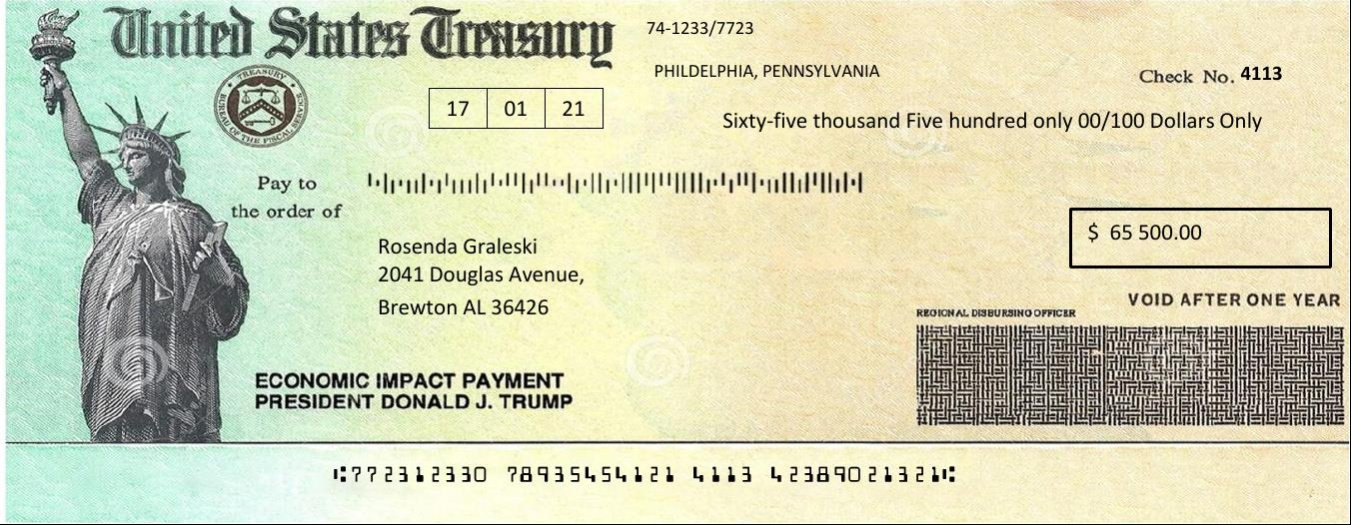

In [10]:
from IPython.display import Image

document_name = f"{adapter_id}/checks-annotations/original_assets/31eb3f65-babd-4410-b9ea-596c7b35989d.jpg"
Image(filename=document_name) 

In [12]:
! pip install amazon-textract-caller

In [13]:
import boto3
from textractcaller.t_call import call_textract, Textract_Features, Query, QueriesConfig, Adapter, AdaptersConfig
import trp.trp2 as t2

textract_client = boto3.client('textract')

def tabulate_query_answers(textract_json):
    d = t2.TDocumentSchema().load(textract_json)
    for page in d.pages:
        query_answers = d.get_query_answers(page=page)
        display(pd.DataFrame(query_answers))

queries = []
queries.append(Query(text="What is the check#?", alias="CHECK_NUMBER", pages=["*"]))
queries.append(Query(text="What is the date?", alias="DATE", pages=["*"]))
queries.append(Query(text="What is the check amount in words?", alias="CHECK_AMOUNT_WORDS", pages=["*"]))
queries.append(Query(text="What is the dollar amount?", alias="DOLLAR_AMOUNT", pages=["*"]))
queries.append(Query(text="Who is the payee?", alias="PAYEE_NAME", pages=["*"]))
queries.append(Query(text="What is the customer account#", alias="ACCOUNT_NUMBER", pages=["*"]))
queries.append(Query(text="what is the payee address?", alias="PAYEE_ADDRESS", pages=["*"]))
queries.append(Query(text="What is the bank routing number?", alias="BANK_ROUTING_NUMBER", pages=["*"]))
queries.append(Query(text="What is the memo", alias="MEMO", pages=["*"]))
queries.append(Query(text="What is the account name/payer/drawer name?", alias="ACCOUNT_NAME", pages=["*"]))
queries.append(Query(text="What is the bank name/drawee name?", alias="BANK_NAME", pages=["*"]))
queries.append(Query(text="What is the MICR line?", alias="MICR_LINE", pages=["*"]))


queries_config = QueriesConfig(queries=queries)

In [14]:
print("Calling Pre-built Textract Queries")

textract_json_prebuilt = call_textract(input_document=document_name,
                  boto3_textract_client=textract_client,
                  features=[Textract_Features.QUERIES],
                  queries_config=queries_config)

tabulate_query_answers(textract_json_prebuilt)

Calling Pre-built Textract Queries


,0,1,2
0,What is the check#?,CHECK_NUMBER,4113
1,what is the payee address?,PAYEE_ADDRESS,"2041 Douglas Avenue, Brewton AL 36426"
2,What is the account name/payer/drawer name?,ACCOUNT_NAME,
3,What is the memo,MEMO,
4,What is the check amount in words?,CHECK_AMOUNT_WORDS,Sixty-five thousand five hundred only 00/100 D...
5,What is the date?,DATE,17 01 21
6,What is the bank routing number?,BANK_ROUTING_NUMBER,78935454121
7,What is the dollar amount?,DOLLAR_AMOUNT,$ 65 500.00
8,What is the customer account#,ACCOUNT_NUMBER,42389021321
9,Who is the payee?,PAYEE_NAME,Rosenda Graleski


In [15]:
adapter1 = Adapter(adapter_id=adapter_id, version=adapter_version, pages=["*"])
adapters_config = AdaptersConfig(adapters=[adapter1])
print(f"Calling Custom Queries with Adapter: {adapter_id} and AdapterVersion: {adapter_version}")

textract_json_with_adapter = call_textract(input_document=document_name,
                  boto3_textract_client=textract_client,
                  features=[Textract_Features.QUERIES],
                  queries_config=queries_config,
                  adapters_config=adapters_config)

tabulate_query_answers(textract_json_with_adapter)

Calling Custom Queries with Adapter: ad9e1d294dbd and AdapterVersion: 1


InvalidParameterException: An error occurred (InvalidParameterException) when calling the AnalyzeDocument operation: The adapter version is not in a valid status for inference operation.

### Step 2.7 : Clean-up resources
You can always [improve your adapter performance by adding more training data set](https://docs.aws.amazon.com/textract/latest/dg/textract-adapters-tutorial.html#textract-adapters-tutorial-improving)

You can choose to delete the adapter version or the adapter.
When deleting the entire adapter, you must delete all adapter versions first and then proceed to delete the adapter.  

In [ ]:
response = textract_client.delete_adapter_version(
    AdapterId=adapter_id,
    AdapterVersion=adapter_version
)
if response["ResponseMetadata"]["HTTPStatusCode"] == 200:
    print(f"Adapter Version: {adapter_version} successfully deleted")


response = textract_client.delete_adapter(
    AdapterId=adapter_id
)
if response["ResponseMetadata"]["HTTPStatusCode"] == 200:
    print(f"Adapter ID: {adapter_id} successfully deleted")
